In [7]:
using Pkg
using Plots
using Statistics
using LinearAlgebra
using ForwardDiff
import PyPlot as py
using FFTW
using SpecialFunctions
using ColorSchemes
using PyCall
using DelimitedFiles
using Images
using SparseArrays
using BenchmarkTools
using DelimitedFiles
using JLD
include("..//source//tikhonov2d_iterative.jl");
include("..//source//dericheFilter.jl");

# Gaussian Decomposition timings

Compute timings for Gaussian decomposition

In [10]:
#kernel fit
@time begin 
    A, Sx, Sy, c0  =  gaussianKernelFit(1,100,7; linOpt = 1);
end;

  0.000403 seconds (2.50 k allocations: 53.922 KiB)


In [11]:
#using non-lienear optimization
@time begin 
    A, Sx, Sy, c0  =  gaussianKernelFit(1,100,7; linOpt = 0);
    improve(A,Sx,Sy,c0,1,100);
end;

  0.099452 seconds (2.60 k allocations: 75.312 KiB)


# Frequency Plots

Plot Gaussian fit result in Fourier Domain

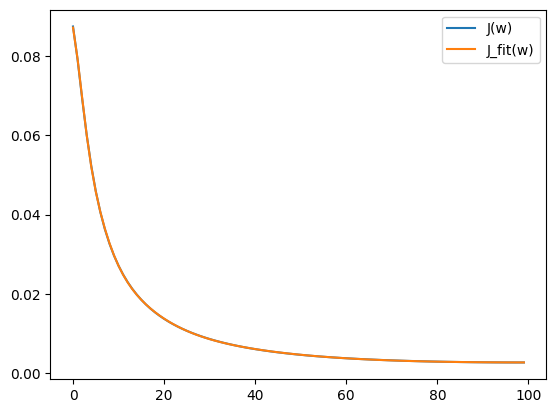

PyObject <matplotlib.legend.Legend object at 0x000000000175DD30>

In [12]:
lx = 80
ly = 30

t = zeros(100)
for i =1:100
    t[i] = Jfun(lx,ly,pi*i/100)
end
py.plot(t)
py.plot(gaussianKernelFitPlot(lx, ly, 20; linOpt=1))
py.legend(["J(w)", "J_fit(w)"])

# Routine to filter RGB image with FFT

In [13]:
function fftfilter2D(img,lx,ly)
    channels, N, M = size(img)
    N2 = 2*N; #increase image size to avoid circular filtering
    M2 = 2*M
    
    g = zeros(ComplexF64, channels, N2, M2)
    g[:,1:N,1:M] = img #embbed image
    
    g = fft(g)
    for i =1:N2, j=1:M2
        w = 2*pi*(i-1)/N2
        xi = 2*pi*(j-1)/M2
        g[:,i,j] = g[:,i,j]/(1+2*lx*(1-cos(w))+2*ly*(1-cos(xi)))
    end
    
    return clamp01.(real.(ifft(g)))[:,1:N,1:M] #clamp values in [0,1]
end;


# Impulse Response

Comparing the impulse response obtained from FFT with the impulse response from the Deriche Recursive filter

assess_psnr(fftRes, dericheRes, 1) = 104.64693113018569
norm(fftRes - dericheRes) / norm(fftRes) = 0.015005404888169998
norm(fftRes - dericheRes, 1) / norm(fftRes, 1) = 0.015163302729180785


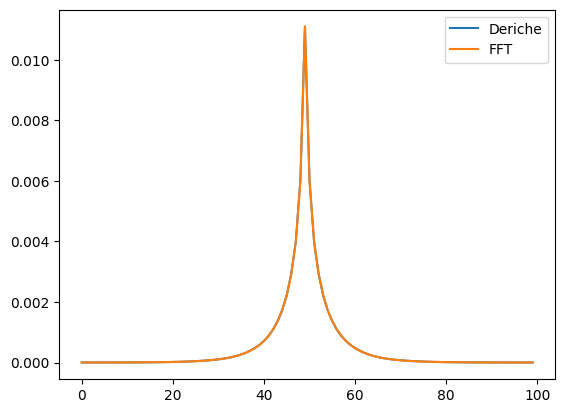

PyObject <matplotlib.legend.Legend object at 0x0000000001B9DEE0>

In [14]:
N = 100
p = N÷2
L = N
nGaussian =5
img = zeros(1,N,N)
img[1,p, p] = 1
lx = 70
ly = 40
fftRes = fftfilter2D(img,lx,ly)[1,1:L,1:L];
dericheRes =  recursiveFilter2D(img,lx,ly, nGaussian)[1,1:L,1:L];
dericheRes =  recursiveFilter2Doptimize(img,lx,ly, nGaussian)[1,1:L,1:L]

@show assess_psnr(fftRes,dericheRes,1)
@show norm(fftRes-dericheRes)/norm(fftRes)
@show norm(fftRes-dericheRes,1)/norm(fftRes,1)

py.plot(dericheRes[p,:] .+ 1e-6)
py.plot(fftRes[p,:] .+ 1e-6)
py.legend(["Deriche","FFT"])

2D plot of the error distribution

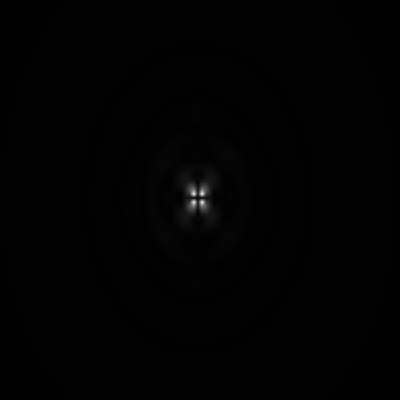

In [15]:
imresize(
colorview(Gray,imadjustintensity(abs.(fftRes-dericheRes))), ratio=4.0)

# Single Image Precision

Compare the recursive filtered image against the FFT filtered image

  7.975672 seconds (935.65 k allocations: 3.224 GiB, 12.86% gc time, 3.94% compilation time)
rel error: 0.007988888716367335
psnr: 49.243777480707855
extrema(-1.9294394985813406, 3.198642515696427)


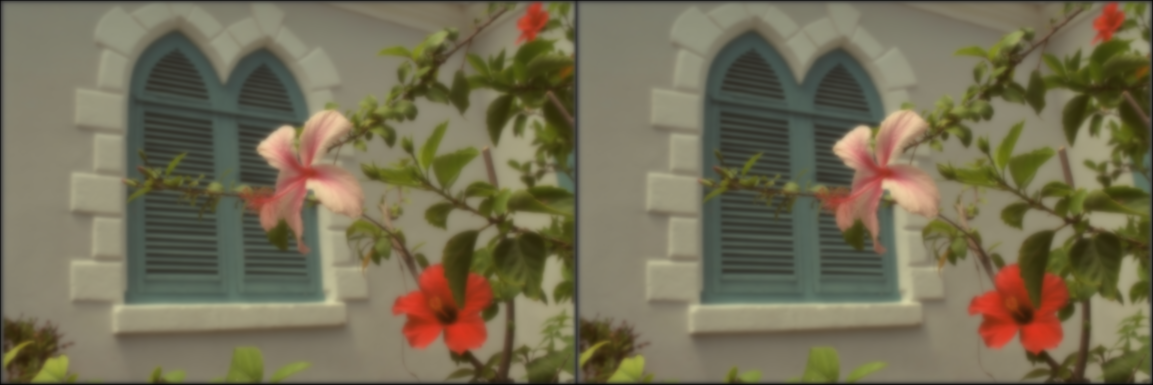

In [16]:
lx = 15;
ly = 15;
nGaussian =5;

img = load("../data/kodak7.jpg") .|>RGB{Float64}  |>channelview

fftFiltered = fftfilter2D(img,lx,ly)

@time gaussianFiltered = 
        recursiveFilter2D(img, lx,ly, nGaussian, linOpt=1)

im1 = colorview(RGB, fftFiltered)
im2 = colorview(RGB, gaussianFiltered);

print("rel error: ",norm(fftFiltered .- gaussianFiltered)/norm(fftFiltered),"\n")
print("psnr: ",assess_psnr(fftFiltered,gaussianFiltered,1),"\n")
print("extrema", extrema(fftFiltered-gaussianFiltered).*255, "\n")
colorview(RGB,hcat(im1,im2))

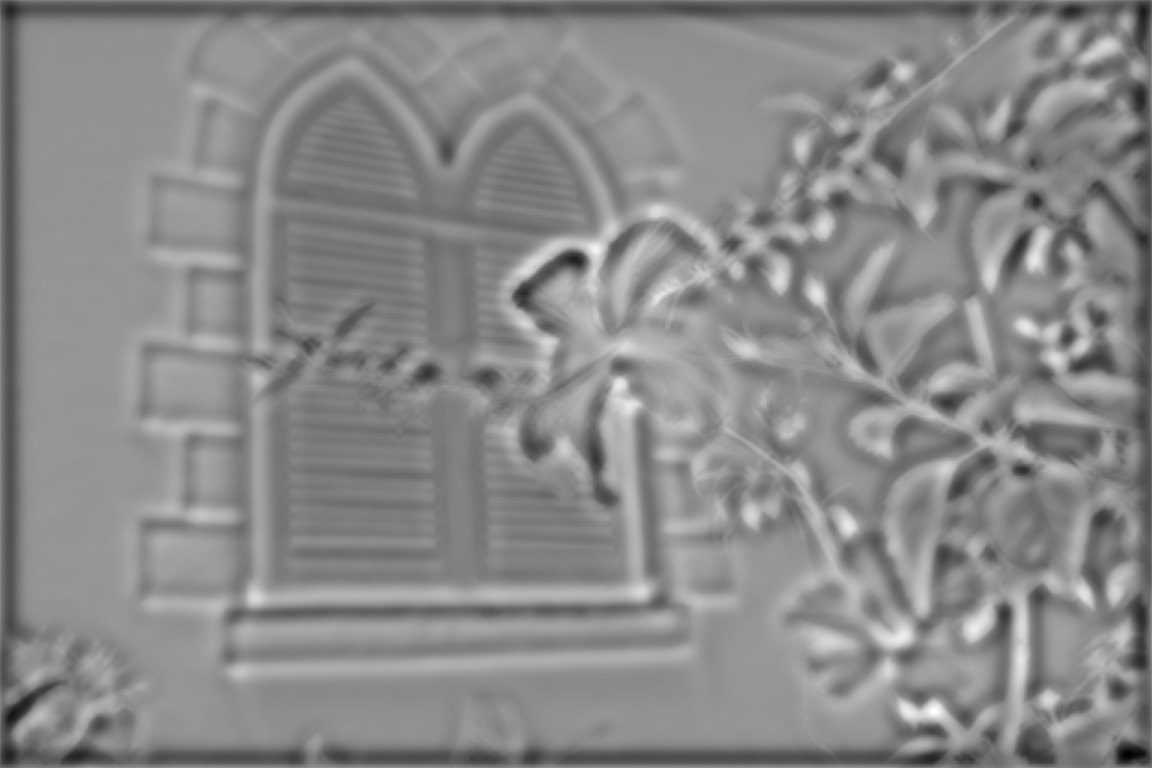

In [18]:
colorview(Gray,imadjustintensity(fftFiltered-gaussianFiltered)[1,:,:])

# Using Optimizer

Using non-linear optimization in spatial domain

In [27]:
#Exact kernel from ift
function extractKernel2d(lx,ly,n,N)
    g = zeros(ComplexF64,n,n)
    for i =1:n, j=1:n
        w = 2*pi*(i-1)/n
        xi = 2*pi*(j-1)/n
        g[i,j] = 1/(1+2*lx*(1-cos(w))+2*ly*(1-cos(xi)))#*exp(im*w)*exp(im*xi)
    end
     g = real.(FFTW.ifft(g))
    return g[1:N,1:N]
end;

## Single image

  4.630022 seconds (593.83 k allocations: 3.033 GiB, 9.75% gc time)
assess_psnr(fftFiltered, gaussianFiltered, 1) = 53.40011715858347


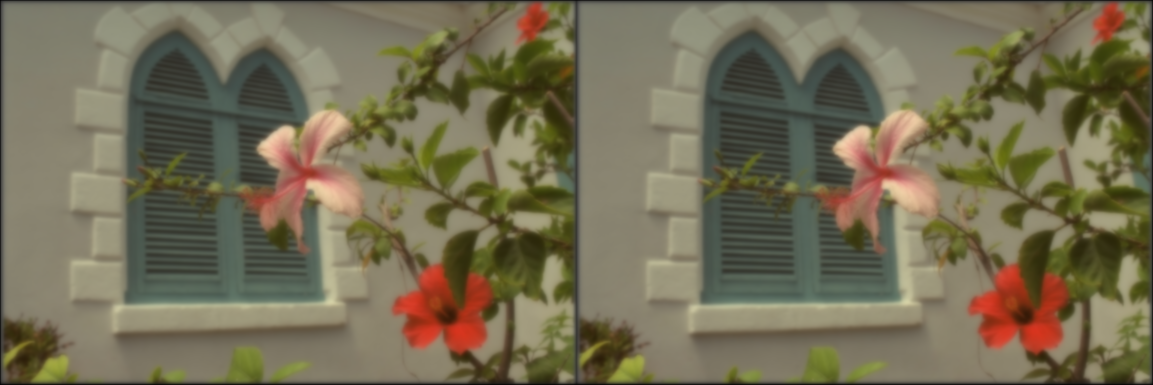

In [30]:
lx = 15
ly = 15
nGaussian = 6;

img = load("../data/kodak7.jpg") |>channelview

fftFiltered = fftfilter2D(img,lx,ly)
@time gaussianFiltered = recursiveFilter2Doptimize(img, lx,ly, nGaussian)
im1 = colorview(RGB, fftFiltered)
im2 = colorview(RGB, gaussianFiltered);

@show assess_psnr(fftFiltered,gaussianFiltered,1)

colorview(RGB,hcat(im1,im2))

# Plot C++ implementation result

Compare the impulse response from the C++ implementation and the computed Gaussian Kernel Decomposition

In [21]:
function getSpatialKernel(A,Sx,Sy,c0,N,Px,Py)
    res = zeros(N,N)
    ng = length(Sx)
 
    for x=1:N, y=1:N
        for k =1:ng
            res[x,y] += A[k]*exp(-(x-Px)^2/2/Sx[k]^2 -(y-Py)^2/2/Sy[k]^2)
        end
    end
    
    res[1,1] += c0
    
    return res
end;

In [22]:
#using precomputed parameters

A = [0.0007529296964615122, 0.0008367529266638894, 0.0006450617864747959,
                  0.0005213929956621048, 0.0003981768137922748, 0.00032428002360665784,
                  0.0001996767865228412];

Sx = [0.9256926546479348, 1.66591945428758, 3.241463860181495,
               5.347072133914192, 8.752160665039751, 12.895919059006964,
               24.433838861919735];
Sy = [0.6545635533961315, 1.1779829430373405, 2.2920610765054583,
               3.7809509653843483, 6.1887121562837715, 9.118791816256666,
               17.27733314968284];


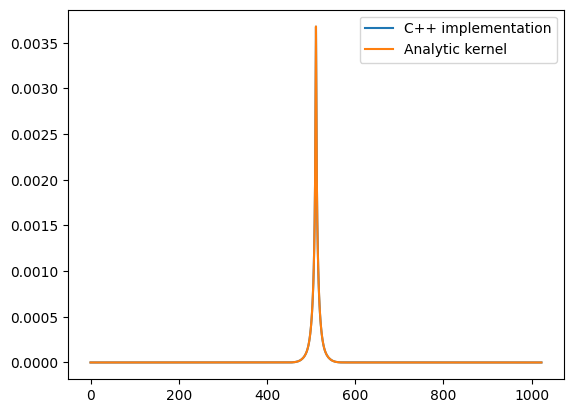

PyObject <matplotlib.legend.Legend object at 0x0000000000EB7730>

In [38]:
K = readdlm("..//source//kernel.csv", ',');
N=1024
iS = 1
L = 20
Px = N÷2
Py = N÷2
eK = getSpatialKernel(A[iS:end] ,Sx[iS:end],Sy[iS:end],0,N, Px, Py);
py.plot(K[Px+1,2:end])
py.plot(eK[Px,1:end-1])
py.legend(["C++ implementation", "Analytic kernel"])

# Compute (ly,lx) pairs for analysis

To compute the errors the user should execute the file homogeneous_error_threaded.jl

In [19]:
#err2 = load("err2.jld","data");
err1 = load("..\\homog_error\\err1.jld","data");
err2 = load("..\\homog_error\\err2.jld","data");
psnr = load("..\\homog_error\\psnr.jld","data");

ierr1 = load("..\\homog_error\\improv_err1.jld","data");
ierr2 = load("..\\homog_error\\improv_err2.jld","data");
ipsnr = load("..\\homog_error\\improv_psnr.jld","data");

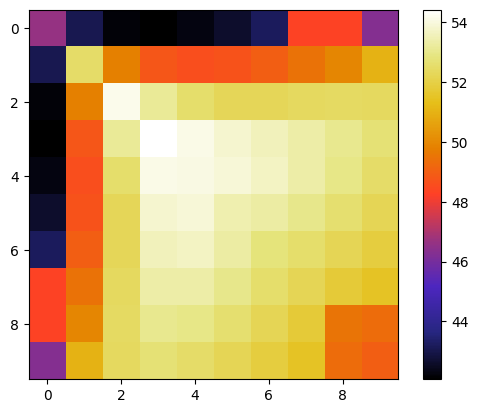

PyObject <matplotlib.colorbar.Colorbar object at 0x00000000019C2970>

In [20]:
py.imshow(minimum(psnr; dims=4)[2,:,:], cmap=:CMRmap);
py.colorbar()

# Linear optimized

In [41]:

gaussian_4_mean_psnr = mean(psnr[1,:,:,:])
gaussian_4_std_psnr = std(psnr[1,:,:,:])
gaussian_4_min_psnr = minimum(psnr[1,:,:,:])

print("mean psnr = ", gaussian_4_mean_psnr,"\n")
print("std psnr = ", gaussian_4_std_psnr, "\n")
print("minimum psnr = ", gaussian_4_min_psnr)

mean psnr = 47.185330497813034
std psnr = 3.1341894211144554
minimum psnr = 38.098462956380835

In [43]:
gaussian_5_mean_psnr = mean(psnr[2,:,:,:])
gaussian_5_std_psnr = std(psnr[2,:,:,:])
gaussian_5_min_psnr = minimum(psnr[2,:,:,:])

print("mean psnr = ", gaussian_5_mean_psnr,"\n")
print("std psnr = ", gaussian_5_std_psnr, "\n")
print("minimum psnr = ", gaussian_5_min_psnr)

mean psnr = 53.179117521882034
std psnr = 4.154367285007478
minimum psnr = 42.06230572565559

In [42]:
gaussian_6_mean_psnr = mean(psnr[3,:,:,:])
gaussian_6_std_psnr = std(psnr[3,:,:,:])
gaussian_6_min_psnr = minimum(psnr[3,:,:,:])

print("mean psnr = ", gaussian_6_mean_psnr,"\n")
print("std psnr = ", gaussian_6_std_psnr, "\n")
print("minimum psnr = ", gaussian_6_min_psnr)

mean psnr = 45.631252687444345
std psnr = 3.4605917264763595
minimum psnr = 40.6773422248948

# Non linear optimized

In [46]:

gaussian_4_mean_psnr = mean(ipsnr[1,:,:,:])
gaussian_4_std_psnr = std(ipsnr[1,:,:,:])
gaussian_4_min_psnr = minimum(ipsnr[1,:,:,:])

print("mean psnr = ", gaussian_4_mean_psnr,"\n")
print("std psnr = ", gaussian_4_std_psnr, "\n")
print("minimum psnr = ", gaussian_4_min_psnr)

mean psnr = 42.41410357762463
std psnr = 4.987037456162079
minimum psnr = 36.224043386823574

In [45]:
gaussian_5_mean_psnr = mean(ipsnr[2,:,:,:])
gaussian_5_std_psnr = std(ipsnr[2,:,:,:])
gaussian_5_min_psnr = minimum(ipsnr[2,:,:,:])

print("mean psnr = ", gaussian_5_mean_psnr,"\n")
print("std psnr = ", gaussian_5_std_psnr, "\n")
print("minimum psnr = ", gaussian_5_min_psnr)

mean psnr = 53.03601003527111
std psnr = 4.021913128971333
minimum psnr = 46.95358522620087

In [44]:
gaussian_6_mean_psnr = mean(ipsnr[3,:,:,:])
gaussian_6_std_psnr = std(ipsnr[3,:,:,:])
gaussian_6_min_psnr = minimum(ipsnr[3,:,:,:])

print("mean psnr = ", gaussian_6_mean_psnr,"\n")
print("std psnr = ", gaussian_6_std_psnr, "\n")
print("minimum psnr = ", gaussian_6_min_psnr)

mean psnr = 59.30268845888608
std psnr = 3.8060135575188965
minimum psnr = 48.277102376399895